In [1]:
from scipy import optimize
import numpy as np
from math import sqrt
from scipy.stats import norm
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# load the relevant optionsdata corresponding to our assigned date 18-03-2004
optionsData = pd.read_csv("input resources/OptionData.csv")
# print("Size: ", optionsData.shape)
optionsData.head()

,Trade dAte,Expiry Date,Put=1 Call=0,Strike x 1000,Bid Price,Ask Price,Volume,Implied Vol,Delta,Open Interest,Vega
0,18/03/04,17/04/04,0,1010000.0,119.7,121.7,0,0.30257,0.91107,140,49.491
1,18/03/04,17/04/04,0,1010000.0,114.4,116.4,0,0.28616,0.91272,0,48.795
2,18/03/04,17/04/04,0,1020000.0,109.6,111.6,0,0.27986,0.90713,0,51.135
3,18/03/04,17/04/04,0,1030000.0,100.5,102.5,0,0.27513,0.88823,33,58.627
4,18/03/04,17/04/04,0,1030000.0,95.7,97.7,0,0.26763,0.88179,0,61.044


### Initial Data Cleanup (dropping options with volume < 100) & segregating the call & put data 

In [3]:
# data cleanup and segregation of call & put options
optionsData['Strike'] = optionsData['Strike x 1000']/1000
optionsDataCleaned = optionsData[optionsData.Volume >= 100]
optionsDataCleaned = optionsDataCleaned[['Trade dAte', 'Expiry Date', 'Put=1 Call=0', 'Strike', 'Bid Price', 'Ask Price', 'Volume', 'Implied Vol', 'Delta ', 'Open Interest', 'Vega']]
optionsDataCleaned.reset_index(inplace=True, drop=True)
# print("Options Data Cleaned shape: ", optionsDataCleaned.shape)

# call data
callData = optionsDataCleaned[optionsDataCleaned['Put=1 Call=0'] == 0]
callData = callData[callData.columns.drop('Put=1 Call=0')]
callData.reset_index(inplace=True, drop=True)
# print("\nCall Data shape: ", callData.shape)
callData.to_csv(path_or_buf='output resources/CallData.csv', index=False)

# put data
putData = optionsDataCleaned[optionsDataCleaned['Put=1 Call=0'] == 1]
putData = putData[putData.columns.drop('Put=1 Call=0')]
putData.reset_index(inplace=True, drop=True)
# print("\nPut Data shape: ", putData.shape)
putData.to_csv(path_or_buf='output resources/PutData.csv', index=False)

---

### Q1 (a) Obtaing the appropriate interest rate 

In [4]:
# load the Zero Rate data for our trade date
zeroRateData = pd.read_csv("input resources/ZeroCurve.csv")
zeroRateData = zeroRateData[zeroRateData.Date == '18/03/2004']
# print("Size: ", zeroRateData.shape)
zeroRateData.head()

,Date,Days,Rate
90968,18/03/2004,11,1.082028
90969,18/03/2004,34,1.103620
90970,18/03/2004,62,1.116676
90971,18/03/2004,90,1.127123
90972,18/03/2004,125,1.140654


In [5]:
# pick the most relevant rate that corresponds to the duration of our option till expiration
optionExpiryDays = 30
timeToExpiry = optionExpiryDays / 365
zeroRate = (zeroRateData.iloc[(zeroRateData.Days - optionExpiryDays).abs().argmin()]['Rate']) / 100
print("Time to option expiry: ", timeToExpiry)
print("\nRelevant zero rate: ", zeroRate)

Time to option expiry:  0.0821917808219178

Relevant zero rate:  0.011036200000000001


---

### Q1 (b) Obtain the relevant dividend yield rate for the SPX500 

In [6]:
# load the SPX Div Yield data for our trade date
divYieldData = pd.read_csv("input resources/SPXDivYield.csv")
divYield = (divYieldData[divYieldData.Date == '18/03/2004']['Rate'].item()) / 100
print("Relevant dividend yield: ", divYield)

Relevant dividend yield:  0.016322859999999998


---

### Q1 (c) Price the option using BSM formula and compare to the mid-point of corresponding option bid/ask spread.

In [7]:
# load the SPX Daily data for our trade date
spxDailyData = pd.read_csv("input resources/SPXDaily1950.csv")
spxSpot = spxDailyData[spxDailyData.Date == '18/03/04']['Adj Close'].item()
print("Spot Price of SPX on trade date: ", spxSpot)

Spot Price of SPX on trade date:  1122.319946


Fetch call & put options with strike ~ spot price of the underlying (SPX) on our trade date (ATM)

In [8]:
callAtmData = callData.iloc[(callData.Strike - spxSpot).abs().argmin()]
putAtmData = putData.iloc[(putData.Strike - spxSpot).abs().argmin()]

In [9]:
class BsOption:
    '''
    The BsOption object is used to calculate the option price
    for both calls and puts using the BS formula

    Args:
        spot (float): Spot price of underlying
        strike (float): Strike price of option
        time (float): Time to option expiry (annualised)
        intRate (float): Risk-free interest rate
        sigma (float): Implied volatility of the underlying (annualised)
        divY (float): Dividend yield of underlying (annualised)

    Attributes:
        S (float): This is where we store spot
        K (float): This is where we store strike
        T (float): This is where we store time to expiry
        r (float): This is where we store int rate
        sigma (float): This is where we store Imp vol
        q (float): This is where we store div yield
    '''
    
    def __init__(self, spot, strike, time, intRate, sigma, divY=0):
        self.S = spot
        self.K = strike
        self.T = time
        self.r = intRate 
        self.sigma = sigma
        self.q = divY
        
    
    @staticmethod
    def N(x):
        '''
        Returns CDF
        '''
        return norm.cdf(x)
    
    @staticmethod
    def N_prime(x):
        '''
        Returns PDF
        '''
        return norm.pdf(x)
        
    @property
    def params(self):
        return {'S': self.S, 
                'K': self.K, 
                'T': self.T, 
                'r':self.r,
                'q':self.q,
                'sigma':self.sigma}
    
    def d1(self):
        '''Computes the d1 element of BS formula

        Returns:
            (float): value of d1 in the BS formula
        '''
        return (np.log(self.S/self.K) + (self.r -self.q + (self.sigma**2/2))*self.T) \
                                / (self.sigma*np.sqrt(self.T))
    
    def d2(self):
        '''Computes the d2 element of BS formula

        Returns:
            (float): value of d2 in the BS formula
        '''
        return self.d1() - self.sigma*np.sqrt(self.T)
    
    def _call_value(self):
        '''Computes the call option price using the BS formula

        Returns:
            (float): call option price
        '''
        return self.S*np.exp(-self.q*self.T)*self.N(self.d1()) - \
                    self.K*np.exp(-self.r*self.T) * self.N(self.d2())
                    
    def _put_value(self):
        '''Computes the put option price using the BS formula

        Returns:
            (float): put option price
        '''
        return self.K*np.exp(-self.r*self.T) * self.N(-self.d2()) -\
                self.S*np.exp(-self.q*self.T)*self.N(-self.d1())
    
    def price(self, optType = 'C'):
        '''Returns the corresponding option price computed using BS formula

        Args:
            optType (str): option type (C for call, P for put)

        Raises:
            ValueError: Unrecognized option type

        Returns:
            (float): option price
        '''
        if optType == 'C':
            return self._call_value()
        if optType == 'P':
            return self._put_value()
        else:
            raise ValueError('Unrecognized option type: please input either C for call or P for put')

In [10]:
# compute the BS price for call ATM option
callAtmPrice = BsOption(spot=spxSpot, strike=callAtmData.Strike, time=timeToExpiry, intRate=zeroRate, divY=divYield, sigma=callAtmData['Implied Vol']).price(optType='C')
print("BS option price for ATM call: ", callAtmPrice)

# compute Call ATM bid-ask mid value
callAtmBidAskMid = (callAtmData['Bid Price'] + callAtmData['Ask Price']) / 2
print("\nBid-Ask mid point value for ATM call option: ", callAtmBidAskMid)

BS option price for ATM call:  22.774385380631315

Bid-Ask mid point value for ATM call option:  22.05


In [11]:
# compute the BS price for put ATM option
putAtmPrice = BsOption(spot=spxSpot, strike=putAtmData.Strike, time=timeToExpiry, intRate=zeroRate, divY=divYield, sigma=putAtmData['Implied Vol']).price(optType='P')
print("BS option price for ATM put: ", putAtmPrice)

# compute put ATM bid-ask mid value
putAtmBidAskMid = (putAtmData['Bid Price'] + putAtmData['Ask Price']) / 2
print("\nBid-Ask mid point value for ATM put option: ", putAtmBidAskMid)

BS option price for ATM put:  19.62424974016028

Bid-Ask mid point value for ATM put option:  16.55


---

### Q1 (d) Find an implied volatility for which the B-S-M formula price matches the midpoint of the Option Metrics Bid/Ask spread exactly

We'll use the Newton Raphson Method, the fastest root-finding approximation method, to compute the implied volatility for which the BSM price matches exactly with the mid-point of ATM call bid-ask spread.

#### Newton Raphson Method:

 $\text{It's given by the equation, }$
 $$\displaystyle{x}_{n+1} = {x}_{n} - \frac{f({x}_{n})} {f^{'}({x}_{n})}$$
 
 $\text{where}$ $\displaystyle f({x}_{n})$ $\text{is a function that is the theoretical (BS) option price – the actual option price,}$ 
 $\displaystyle f^{'}({x}_{n})$ $\text{is the Vega, or the option price sensitivity to implied volatility}$
 $$\displaystyle f^{'}({x}_{n}) = {S}{N}^{'}(d_{1})\sqrt{T}$$

In [12]:
def compute_sigma_newton(S, K, r, t, q, actual_price, c_p, maxIterations=1000, diffThreshold=0.01):
    # assume the starting sigma to be 0.5, which is just an arbitrary number
    _sigma = 0.5 
    
    for i in range(maxIterations):
        _bsOptionObj = BsOption(spot=S, strike=K, time=t, intRate=r, divY=q, sigma=_sigma)
        _bs_price = _bsOptionObj.price(optType=c_p)
        _diff = actual_price - _bs_price
        _pdf = _bsOptionObj.N_prime(_bsOptionObj.d1())
        _vega = S * _pdf * sqrt(t)
        if abs(_diff) < diffThreshold:
            return _sigma
        _sigma += _diff/_vega
        
    return _sigma

In [13]:
# compute the implied vol for ATM call option
callAtmCalSigma = compute_sigma_newton(S=spxSpot, K=callAtmData.Strike,  
                                                                  r=zeroRate, t=timeToExpiry, 
                                                                q=divYield, actual_price=callAtmBidAskMid, c_p='C')
print("Computed implied vol for ATM call: ", callAtmCalSigma)
print("\nActual implied vol used for ATM call BS price: ", callAtmData['Implied Vol'])

Computed implied vol for ATM call:  0.16496548488548052

Actual implied vol used for ATM call BS price:  0.17058


In [14]:
# compute the implied vol for ATM put option
putAtmCalSigma = compute_sigma_newton(S=spxSpot, K=putAtmData.Strike,  
                                                                  r=zeroRate, t=timeToExpiry, 
                                                                q=divYield, actual_price=putAtmBidAskMid, c_p='P')
print("Computed implied vol for ATM put: ", putAtmCalSigma)
print("\nActual implied vol used for ATM put BS price: ", putAtmData['Implied Vol'])

Computed implied vol for ATM put:  0.1362815586597252

Actual implied vol used for ATM put BS price:  0.16027


---

### Q1 (e) Does this match the implied volatility in the Option Metrics data?

TODO

---
---

### Q2 (a) The sensitivity of the Black-Scholes option price to changes in volatility, σ (from σ =5% to σ =80% in steps of 5%)

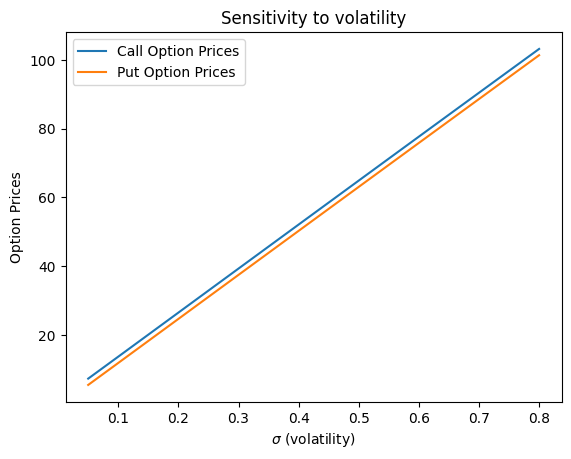

In [15]:
# Range of values from 5% to 80% in steps of 5%
sigmaRange = np.arange(0.05, 0.85, 0.05)

callPricesForSigma = [BsOption(spot=spxSpot, strike=callAtmData.Strike, time=timeToExpiry, \
                               intRate=zeroRate, divY=divYield, sigma=sig) 
                      .price(optType='C') for sig in sigmaRange]
putPricesForSigma = [BsOption(spot=spxSpot, strike=putAtmData.Strike, time=timeToExpiry, \
                               intRate=zeroRate, divY=divYield, sigma=sig) 
                      .price(optType='P') for sig in sigmaRange]

# plot the sigma values against call & put prices
plt.plot(sigmaRange, callPricesForSigma, label='Call Option Prices')
plt.plot(sigmaRange, putPricesForSigma, label='Put Option Prices')
plt.xlabel('$\sigma$ (volatility)')
plt.ylabel('Option Prices')
plt.title('Sensitivity to volatility')
plt.legend()

As we would expect, when we hold the other variables constant, and increase the volatility parameter both calls and puts increase in value, in what appears to be a linear fashion as shown below.

To understand why the calls value seems to be greater than the put with respect to volatility, change the interest rate 'r' to 0 and notice that the curve coincide exactly. Rather than making plots for the effect on interest rates, we can deduce from this that an increase in interest rates increases the value of calls and decreases the value of puts. 

---


### Q2 (b) Using delta and gamma in a Taylor series expansion, superimpose a plot of the projected price around the price of your option using a grid of price changes in the range -30% to +30%.

TODO

---

### Q2 (c) The sensitivity of the Black-Scholes option price to changes in the time to maturity T (T= 1 week, 1 month, 1 quarter, 6 months, 1 year, 5 years)

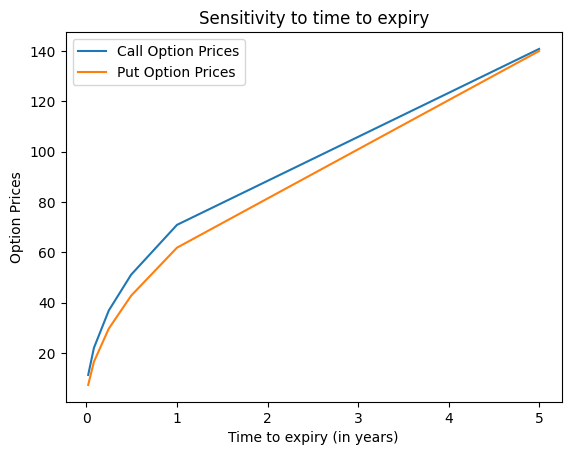

In [16]:
# Time range from 1 week to 5 years (all annualised)
expiryTimeRange = [7.0/365, 30.0/365, 90.0/365, 180.0/365, 1.0, 5.0]

callPricesForTime = [BsOption(spot=spxSpot, strike=callAtmData.Strike, time=time, \
                               intRate=zeroRate, divY=divYield, sigma=callAtmCalSigma) 
                      .price(optType='C') for time in expiryTimeRange]
putPricesForTime = [BsOption(spot=spxSpot, strike=putAtmData.Strike, time=time, \
                               intRate=zeroRate, divY=divYield, sigma=putAtmCalSigma) 
                      .price(optType='P') for time in expiryTimeRange]

# plot the time to expiry values against call & put prices
plt.plot(expiryTimeRange, callPricesForTime, label='Call Option Prices')
plt.plot(expiryTimeRange, putPricesForTime, label='Put Option Prices')
plt.xlabel('Time to expiry (in years)')
plt.ylabel('Option Prices')
plt.title('Sensitivity to time to expiry')
plt.legend()

As we increase time we increase the uncertainty regarding the future price. Since uncertainty is to the options holder's benefit, the price of the option increases with time. Again, we can observe that by setting the interest rate to zero, the difference between puts and calls is eliminated.

---

### Q2 (d) The sensitivity of the Black-Scholes option price to changes in the interest rate r. (e.g. r in the range 0% to 14%, in steps of 0.25%)

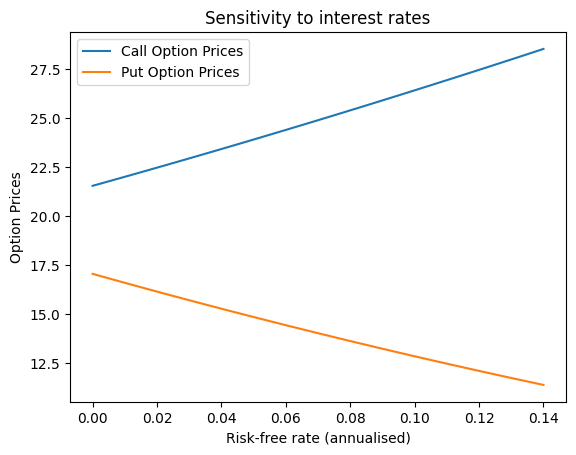

In [17]:
# Interest Rate range from 0% to 14% in steps of 0.25%
intRateRange = np.arange(0, 0.1425, 0.0025)

callPricesForInt = [BsOption(spot=spxSpot, strike=callAtmData.Strike, time=timeToExpiry, \
                               intRate=intR, divY=divYield, sigma=callAtmCalSigma) 
                      .price(optType='C') for intR in intRateRange]
putPricesForInt = [BsOption(spot=spxSpot, strike=putAtmData.Strike, time=timeToExpiry, \
                               intRate=intR, divY=divYield, sigma=putAtmCalSigma) 
                      .price(optType='P') for intR in intRateRange]

# plot the time to expiry values against call & put prices
plt.plot(intRateRange, callPricesForInt, label='Call Option Prices')
plt.plot(intRateRange, putPricesForInt, label='Put Option Prices')
plt.xlabel('Risk-free rate (annualised)')
plt.ylabel('Option Prices')
plt.title('Sensitivity to interest rates')
plt.legend()

As mentioned earlier, call option prices have a positive relationship with the risk-free interest rates, whereas, put option prices genrally tend to fall with any rise in interest rates. This can be observed in the above sensitivity plot.


TODO: Compare and contrast the above results with regards to option theory and option hedging strategy.

---
---

### Q3 Compute and plot the intrinsic value function for both ATM call & put options

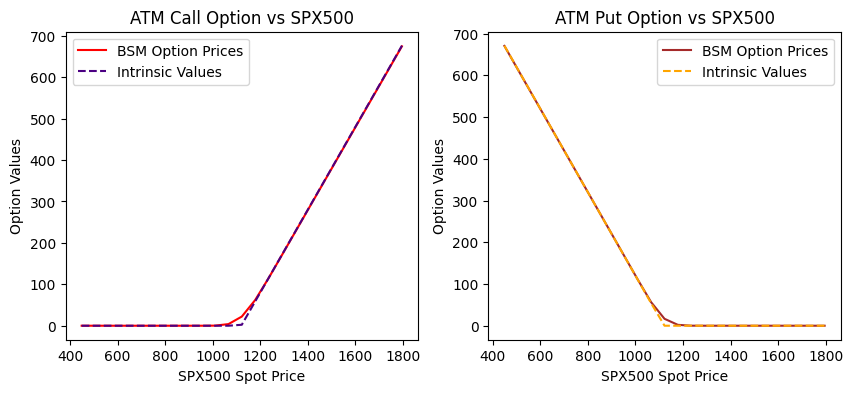

In [18]:
pctRange = np.round(np.arange(-0.6, 0.65, 0.05), decimals=2)
spxSpotRange = [(1+pct) * spxSpot for pct in pctRange]

# compute call option values & their intrinsic values
q3CallPrices = [BsOption(spot=spot, strike=callAtmData.Strike, time=timeToExpiry, \
                               intRate=zeroRate, divY=divYield, sigma=callAtmCalSigma)
                .price(optType='C') for spot in spxSpotRange]
q3CallIV = [max(spot-callAtmData.Strike, 0) for spot in spxSpotRange]

# plot of call option values
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(spxSpotRange, q3CallPrices, label='BSM Option Prices', color='red')
plt.plot(spxSpotRange, q3CallIV, label='Intrinsic Values', linestyle='dashed', color='indigo')
plt.xlabel('SPX500 Spot Price')
plt.ylabel('Option Values')
plt.title('ATM Call Option vs SPX500')
plt.legend()

# compute put option values & their intrinsic values
q3PutPrices = [BsOption(spot=spot, strike=putAtmData.Strike, time=timeToExpiry, \
                               intRate=zeroRate, divY=divYield, sigma=putAtmCalSigma)
                .price(optType='P') for spot in spxSpotRange]
q3PutIV = [max(putAtmData.Strike - spot, 0) for spot in spxSpotRange]

# plot of put option values
plt.subplot(1, 2, 2)
plt.plot(spxSpotRange, q3PutPrices, label='BSM Option Prices', color='brown')
plt.plot(spxSpotRange, q3PutIV, label='Intrinsic Values', linestyle='dashed', color='orange')
plt.xlabel('SPX500 Spot Price')
plt.ylabel('Option Values')
plt.title('ATM Put Option vs SPX500')
plt.legend()

TODO

Discuss your results in relation to option theory and whether you would ever exercise your option (or would you sell it to someone instead for the Black Scholes price) for both call & put.

---
---